## 1 - Import packages

In [3]:
#!pip install tensorflow[and-cuda] torch numpy wandb matplotlib monai pillow pynrrd
#!jupyter serverextension enable --py nbresuse #extension that displays the resources/computational power that are used by the notebook
#!jupyter labextension install @jupyterlab/statusbar #extension that adds a progressbar so monitoring the upload is posible

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
import torch
import plotly.graph_objects as go
import os
import numpy as np
import wandb
import matplotlib.pyplot as plt
import glob
import monai
import random
from PIL import Image
import nrrd
from monai.transforms import ToMetaTensord
from torch.utils.data import Dataset
from monai.transforms.transform import Transform
from monai.data.dataloader import DataLoader
from monai.networks.nets import UNet
from monai.networks.nets import DynUNet
from monai.data import DataLoader, CacheDataset
from monai.transforms import (
    Compose, 
    RandRotate, 
    Resize, 
    ToTensor, 
    EnsureType, 
    LoadImage, 
    EnsureChannelFirstd, 
    ScaleIntensityd,
    RandSpatialCropd,
    RandCropByPosNegLabeld,
    Pad, 
    Resized, 
    RandRotated,
    MapTransform,
    Spacingd,
    CenterSpatialCropd,
    EnsureTyped
)
from monai.losses import DiceLoss, FocalLoss, DiceCELoss, SoftclDiceLoss
from monai.optimizers import Novograd
from monai.data import MetaTensor
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from sklearn.model_selection import KFold

2025-04-06 21:28:50.291014: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 21:28:50.329888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-06 21:28:50.329907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-06 21:28:50.329946: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-06 21:28:50.338620: I tensorflow/core/platform/cpu_feature_g

## 2 - Define path


In [2]:
##### CHANGE DATA PATH ACCORDINGLY #####
data_path = "ASOCA"
########################################

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["Normal", "Diseased"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train, val and test folders).")
else:
    print("Congrats! You selected the correct folder :)")
    
print(f'GPU index: {torch.cuda.current_device()}')  # Prints GPU index
print(f'GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}')  # Prints GPU name
print(f'You are logged in at WanB: {wandb.login()}')
print(f'Current working directory: {os.getcwd()}') 

Congrats! You selected the correct folder :)
GPU index: 0
GPU name: Tesla T4


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: j-e-vleugel (j-e-vleugel-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You are logged in at WanB: True
Current working directory: /home/jovyan/Project


## 3 - Define load function, custom transform, 3D plot function, WandB logging

In [3]:
def build_dict_asoca(data_path):
    """
    This function returns a list of dictionaries, each containing the keys 'img' and 'label' 
    with paths to the corresponding NRRD image.
    
    Args:
        data_path (str): Path to the root folder of the ASOCA dataset.
        mode (str): Subset used. Must be 'train', 'val', or 'test'.
        
    Returns:
        List[Dict[str, str]]: List of dictionaries containing paths of NRRD images and labels.
    """
    
    dicts = []
    for label in ["Diseased", "Normal"]:
        image_path = os.path.join(data_path, label,"CTCA")        
        image_files = glob.glob(os.path.join(image_path, "*.nrrd"))
        
        annotation_path = os.path.join(data_path, label, "Annotations")  # Path to annotations
        
        print(f"Looking for images in: {image_path}")
        print(f"Found {len(image_files)} images in {image_path}")
        
        for img_path in image_files:
            img_name = os.path.basename(img_path)
            mask_name = os.path.basename(img_path)
            mask_path = os.path.join(annotation_path, mask_name)
        
            dicts.append({
                    'img': img_path,
                    'mask': mask_path,
                    'label': 1 if label == "Diseased" else 0  # 1 for Diseased, 0 for Normal

                })
    
    return dicts

class LoadASOCAData(Transform):
    """
    Custom MONAI transform to load ASOCA NRRD images and annotations (masks).
    """
    def __init__(self, keys=None):
        pass  # No initialization needed

    def __call__(self, sample):
        # Load image and mask
        img_path = sample['img']
        mask_path = sample['mask']
        image, _ = nrrd.read(img_path)
        mask, _ = nrrd.read(mask_path)

        # Add channel dimension (C, H, W, D)
        image = np.expand_dims(image, axis=0)  # (1, H, W, D)
        mask = np.expand_dims(mask.astype(np.float32), axis=0)  # (1, H, W, D)

        # Convert to MetaTensor (with identity affine)
        img_tensor = MetaTensor(image, affine=np.eye(4))
        mask_tensor = MetaTensor(mask, affine=np.eye(4))

        return {
            'img': img_tensor,
            'mask': mask_tensor,
            'label': torch.tensor(sample['label'], dtype=torch.long)
        }
    
class WindowLeveld(MapTransform):
    """
    Custom transform to set window and level.
    """
    def __init__(self, keys, level=200, window=400):  # Alter the W/L here
        super().__init__(keys)
        self.level = level
        self.window = window

    def __call__(self, data):
        d = dict(data)
        min_val = self.level - self.window / 2
        max_val = self.level + self.window / 2
        
        # Apply window-leveling
        img = np.clip(d["img"], min_val, max_val)
        
        # Convert back to MetaTensor while preserving metadata
        d["img"] = MetaTensor(img, meta=d["img"].meta)  # Preserve metadata!

        return d

def mask_to_point_cloud(mask_volume, voxel_spacing=(0.4, 0.4, 0.6)): #aanpassen aan de andere spacing?
    """
    Convert a 3D mask (H, W, D) into a point cloud and apply real-world scaling.

    Args:
        mask_volume (numpy array): 3D binary mask (H, W, D)
        voxel_spacing (tuple): Real-world spacing (x, y, z) in mm
    
    Returns:
        x, y, z (numpy arrays): Scaled coordinates of nonzero voxels
    """
    # Extract nonzero voxel positions
    x_idx, y_idx, z_idx = np.where(mask_volume > 0)  
    
    # Scale voxel positions to real-world dimensions
    x = x_idx * voxel_spacing[0]  
    y = y_idx * voxel_spacing[1]  
    z = z_idx * voxel_spacing[2] 
    
    return x, y, z  # Return scaled coordinates

def plot_point_cloud(x, y, z, title="3D Mask Point Cloud"):
    """
    Create a Plotly 3D scatter plot from point cloud data with real-world spacing.

    Args:
        x, y, z (numpy arrays): Scaled coordinates of nonzero voxels
        title (str): Title of the plot
    """
    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=2, opacity=0.8, color=z, colorscale="Viridis")
    )])
    
    fig.update_layout(title=title, scene=dict(
        xaxis_title="X (mm)", 
        yaxis_title="Y (mm)", 
        zaxis_title="Z (mm)"
    ))
    
    return fig

def from_compose_to_list(compose_transform):
    return [str(transform) for transform in compose_transform.transforms]

def wandb_masks(mask_output, mask_gt):
    """ Format masks for WandB logging. """
    
    if isinstance(mask_output, np.ndarray):
        mask_output = torch.tensor(mask_output, dtype=torch.float32)
    if isinstance(mask_gt, np.ndarray):
        mask_gt = torch.tensor(mask_gt, dtype=torch.float32)
    
    # Convert to binary segmentation mask
    mask_output = torch.sigmoid(mask_output)
    mask_output = torch.round(mask_output).squeeze().clone().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().clone().detach().cpu().numpy()

    class_labels = {1: 'CTCA'}
    return {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground_truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Logs training/validation losses and visualizes predictions in WandB. """

    log_imgs = []

    for i, (img, mask_output, mask_gt) in enumerate(zip(batch_data['img'], outputs, batch_data['mask'])):
        depth = img.shape[-1]  # Extract depth
        mid_slice_idx = depth // 2  

        img_slice = img[0, :, :, mid_slice_idx].clone().detach().cpu().numpy()
        mask_output_slice = torch.sigmoid(mask_output[0, :, :, mid_slice_idx]).clone().detach().cpu().numpy()
        mask_gt_slice = mask_gt[0, :, :, mid_slice_idx].clone().detach().cpu().numpy()

        mask_output_slice = (mask_output_slice > 0.5).astype(np.uint8)
        mask_gt_slice = np.round(mask_gt_slice).astype(np.uint8)

        # Apply windowing
        Level = 250  
        window = 500
        min_val = Level - (window / 2)
        max_val = Level + (window / 2)
        img_slice = np.clip(img_slice, min_val, max_val)

         # Apply windowing
        img_slice = np.clip(img_slice, min_val, max_val)
        
        # Create a visualization figure
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img_slice, cmap='gray')
        ax[0].set_title("Input Image")
        
        green_colormap = plt.cm.colors.ListedColormap(['black', 'green'])  # black for 0, green for 1 (or any other color scale)
        red_colormap = plt.cm.colors.ListedColormap(['black', 'red'])  # black for 0, red for 1

        # Display the ground truth mask with green colormap
        ax[1].imshow(mask_gt_slice, cmap=green_colormap)
        ax[1].set_title("Ground Truth Mask")

        # Display the predicted mask with red colormap
        ax[2].imshow(mask_output_slice, cmap=red_colormap)
        ax[2].set_title("Predicted Mask")

        plt.tight_layout()

        # Log the image and segmentation mask to WandB
        img_with_mask = wandb.Image(img_slice, masks={"predictions": {"mask_data": mask_output_slice,
                                                       "class_labels": {1: "vessel"}},
                                                      "ground_truth": {"mask_data": mask_gt_slice,
                                                                       "class_labels": {1: "vessel"}}},
            caption=f"Epoch {epoch}: Sample {i+1} CT Scan and Mask")

        log_imgs.append(img_with_mask)
        wandb.log({f"Prediction Epoch {epoch}": wandb.Image(fig)})

        plt.close(fig)  # Prevent memory leaks
        
        # Generate 3D point cloud
        mask_gt_np = mask_gt.cpu().detach().numpy()[0]
        mask_pred_np = mask_output.cpu().detach().numpy()[0]

        # Extract point cloud for GT & Predicted masks
        x_gt, y_gt, z_gt = mask_to_point_cloud(mask_gt_np)
        x_pred, y_pred, z_pred = mask_to_point_cloud(mask_pred_np)
        print(f"ground truth size: {len(x_gt)}")
        print(f"prediction size: {len(x_pred)}")
        
        # Create 3D scatter plot
        fig_gt = plot_point_cloud(x_gt, y_gt, z_gt, title=f"Sample {i+1} Ground Truth")
        fig_pred = plot_point_cloud(x_pred, y_pred, z_pred, title=f"Sample {i+1} Prediction")
        
        # Log 3D point cloud correctly
        wandb.log({f"3D GT Sample {i+1}": fig_gt})
        wandb.log({f"3D Pred Sample {i+1}": fig_pred})
        
        fig_gt.write_html("3D_GT_Sample.html")
        fig_pred.write_html("3D_Pred_Sample.html")

        # Log the HTML file to Weights & Biases
        wandb.log({
            "3D_GT_Sample": wandb.Html(open("3D_GT_Sample.html", "r").read()),
            "3D_Pred_Sample": wandb.Html(open("3D_Pred_Sample.html", "r").read()) })
        # The 3D plots are logged to WandB/project/run/files/media/html

    # Log all other shit
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'gradient_norm': torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0).item(), 
    })


## 4 - Define transforms

In [8]:
train_transform = Compose([
    LoadASOCAData(keys=['img', 'mask']),
    ToMetaTensord(keys=['img', 'mask']), 
    WindowLeveld(keys=['img']),
    RandRotated(keys=['img', 'mask'], range_x=np.deg2rad(10), range_y=np.deg2rad(10), range_z=0, prob=0.5),
    ScaleIntensityd(keys=['img'], minv=0, maxv=1),
    RandCropByPosNegLabeld(keys=['img', 'mask'], label_key = 'mask', spatial_size=(512, 512, 168), pos=1, neg=0, num_samples=1)
])

val_transform = Compose([
    LoadASOCAData(keys=['img', 'mask']),
    ToMetaTensord(keys=['img', 'mask']), 
    WindowLeveld(keys=['img']), 
    ScaleIntensityd(keys=['img'], minv=0, maxv=1),
    RandCropByPosNegLabeld(keys=['img', 'mask'], label_key = 'mask', spatial_size=(512, 512, 168), pos=1, neg=0, num_samples=1)
])

## 5 - Define model, loss function, optimizer and set to GPU

In [9]:
#####
model = UNet(
    spatial_dims=3,
    in_channels=1,  # Grayscale image with 1 channel
    out_channels=1,  # Segmentation mask, usually 1 channel for binary segmentation
    channels=(16, 32, 64, 128),  # Number of channels in each layer
    strides=(2, 2, 1),  # Downsampling and upsampling strides, MAKE SURE THIS MATCHES THE INPUT SIZE, e.g. avoid integers
    kernel_size=3  # Kernel size for convolutions
)

#####
# class CombinedLoss(nn.Module):
#     def __init__(self, dice_weight=0.5, bce_weight=0.5):
#         super(CombinedLoss, self).__init__()
#         self.dice_loss = monai.losses.DiceLoss(sigmoid=True)  # Sigmoid applied internally
#         self.bce_loss = nn.BCEWithLogitsLoss()  # BCE loss

#         # Weighting between losses
#         self.dice_weight = dice_weight
#         self.bce_weight = bce_weight

#     def forward(self, outputs, targets):
#         dice = self.dice_loss(outputs, targets)
#         bce = self.bce_loss(outputs, targets)
#         return self.dice_weight * dice + self.bce_weight * bce

#loss_function = FocalLoss()
loss_function = DiceLoss(sigmoid=True)
#loss_function = CombinedLoss(dice_weight=0.5, bce_weight=0.5)

#####
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

model.to(device)
torch.cuda.empty_cache()

The used device is cuda


## 6 - Load data

In [10]:
##### Load Data #####
data_dicts = build_dict_asoca(data_path)

# Assuming data_dicts is the list of dictionaries containing your data
train_dicts, val_dicts = train_test_split(data_dicts, test_size=0.2, random_state=42) #80/20 split , kfolds an idea in the future?

##### Create Datasets and Dataloaders #####
train_dataset = CacheDataset(data=train_dicts, transform=train_transform, cache_rate=1, num_workers=4)
val_dataset = CacheDataset(data=val_dicts, transform=val_transform, cache_rate=1, num_workers=4)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)


Looking for images in: ASOCA/Diseased/CTCA
Found 20 images in ASOCA/Diseased/CTCA
Looking for images in: ASOCA/Normal/CTCA
Found 20 images in ASOCA/Normal/CTCA


Loading dataset: 100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


## 7 - Train model

In [11]:
run = wandb.init(
    project='ASOCA',
    name='simple_unet_training',
    config={
        'loss_function': str(loss_function),
        'lr': optimizer.param_groups[0]['lr'],
        'train_transform': from_compose_to_list(train_transform),
        'val_transform': from_compose_to_list(val_transform),
        'batch_size': train_dataloader.batch_size,
        'model_name': model.__class__.__name__,
        'optimizer': optimizer.__class__.__name__,
    },
    reinit=True
)

##### Training Loop #####
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data in train_dataloader:
        images = batch_data['img'].to(device).float()
        masks = batch_data['mask'].to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = loss_function(outputs, masks)  
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dataloader)
    
    ##### Validation #####
    model.eval()
    val_loss = 0.0
    dice_score = 0.0
    num_batches = 0
    sample_batch = None  # Store a sample batch for logging
    sample_output = None  # Store the corresponding model outputs for logging

    dice_metric = monai.metrics.DiceMetric(include_background=False, reduction="mean")

    with torch.no_grad():
        for batch_data in val_dataloader:
            images = batch_data['img'].to(device).float()
            masks = batch_data['mask'].to(device).float()
            
            outputs = model(images)
            
            loss = loss_function(outputs, masks)
            val_loss += loss.item()
            
            # Ensure binary masks
            outputs = (torch.sigmoid(outputs) > 0.8).float()
            masks = (masks > 0).float()
            
            # Compute Dice Score safely
            if torch.sum(masks) > 0:  # Ensure non-empty mask
                batch_dice = dice_metric(outputs, masks)
                if not torch.isnan(batch_dice):
                    dice_score += batch_dice.item()
                else:
                    print(f"⚠️ Warning: NaN Dice score in batch {num_batches}!")
            else:
                print(f"⚠️ Skipping batch {num_batches}: Empty mask.")

            num_batches += 1
            
            # Store first batch for visualisation and its outputs
            if sample_batch is None:
                sample_batch = batch_data  # Store input batch (images, masks)
                sample_output = outputs.detach().cpu()  # Store the model's outputs (predictions) for this batch

    avg_val_loss = val_loss / num_batches if num_batches > 0 else 0
    avg_dice_score = dice_score / num_batches if num_batches > 0 else 0  

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Dice: {avg_dice_score}")

    # Log to WandB
    log_to_wandb(epoch, avg_train_loss, avg_val_loss, sample_batch, sample_output)

##### Save Model #####
torch.save(model.state_dict(), "simple_segmentation_model.pth")
wandb.save("simple_segmentation_model.pth")

run.finish()

Epoch 1/100, Training Loss: 0.9979983828961849, Validation Loss: 0.9975903928279877, Dice: 0.01883127319160849
ground truth size: 22857
prediction size: 2108911
Epoch 2/100, Training Loss: 0.9974648524075747, Validation Loss: 0.9970861747860909, Dice: 0.024918948533013463
ground truth size: 22857
prediction size: 2007160
Epoch 3/100, Training Loss: 0.9970727376639843, Validation Loss: 0.9968727305531502, Dice: 0.02823120984248817
ground truth size: 22857
prediction size: 1917531
Epoch 4/100, Training Loss: 0.9967601876705885, Validation Loss: 0.9965859279036522, Dice: 0.03149171592667699
ground truth size: 22857
prediction size: 1821272
Epoch 5/100, Training Loss: 0.9965281542390585, Validation Loss: 0.9964478686451912, Dice: 0.03402673196978867
ground truth size: 17134
prediction size: 1481505
Epoch 6/100, Training Loss: 0.9962704386562109, Validation Loss: 0.9962017238140106, Dice: 0.03476446005515754
ground truth size: 22857
prediction size: 1717746
Epoch 7/100, Training Loss: 0.996

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
gradient_norm,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▃▄▄▅▅▇█▇▄▄▅▇▅▄▆▆▇▆▇
train_loss,████████▇▇▇▇▇▇▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,█████████████████▇▆▆▆▅▅▄▄▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁
epoch,99
gradient_norm,2.25247
train_loss,0.25
val_loss,0.2774


In [43]:
!pip install nibabel
import nibabel as nib
import numpy as np
from monai.data import MetaTensor

class LoadASOCADataTest:
    """
    Custom transform for loading ASOCA data in NIfTI format and preserving metadata.
    """
    def __init__(self, keys=None):
        self.keys = keys

    def __call__(self, sample):
        img_path = sample['img']
        
        # Load the NIfTI image using nibabel
        img_data = nib.load(img_path)
        
        # Get the image data as a NumPy array
        image = img_data.get_fdata()

        # Expand dimensions if needed (e.g., for channel-first format)
        image = np.expand_dims(image, axis=0)  # Shape: (1, H, W, D)

        # Create a MetaTensor with image data and affine matrix
        img_tensor = MetaTensor(image, affine=img_data.affine)
        
        return {'img': img_tensor}

Defaulting to user installation because normal site-packages is not writeable


In [44]:
# import os
# import torch
# import numpy as np
# import nibabel as nib  # You're saving with nib, not nrrd here
# from tqdm import tqdm
# from monai.transforms import Compose, LoadImage, ScaleIntensityd, CenterSpatialCropd
# from monai.data import DataLoader, Dataset

# # Configuration
# asoca_secret_dir = "forDLMIA"
# output_dir = "./predictions_nrrd/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Create output folder
# os.makedirs(output_dir, exist_ok=True)

# # Inference transforms (no cropping or augmentation for test)
# test_transform = Compose([
#     LoadASOCADataTest(keys=['img']),
#     WindowLeveld(keys=['img']),
#     ScaleIntensityd(keys=['img'], minv=0, maxv=1),
#     CenterSpatialCropd(keys=['img'], roi_size=(512, 512, 168))
# ])

# # Prepare dataset and dataloader
# image_filenames = [f for f in os.listdir(asoca_secret_dir)]
# data_dicts = [{"img": os.path.join(asoca_secret_dir, fname)} for fname in image_filenames]
# dataset = Dataset(data=data_dicts, transform=test_transform)
# loader = DataLoader(dataset, batch_size=1, num_workers=4)

# # Inference loop
# with torch.no_grad():
#     for idx, batch in enumerate(tqdm(loader)):
#         image = batch["img"].to(device).float()
        
#         # Model inference
#         output = model(image)
#         pred = (torch.sigmoid(output) > 0.8).float()
#         pred_np = pred.cpu().numpy().astype(np.uint8)[0, 0]

#         # Get original filename to use for saving
#         fname = os.path.basename(data_dicts[idx]['img'])  # Use the index from the loop
#         out_path = os.path.join(output_dir, fname)

#         # Save the prediction as NIfTI
#         nib.save(nib.Nifti1Image(pred_np, np.eye(4)), out_path)

# print(f"Inference complete. Segmentations saved to: {output_dir}")


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

Inference complete. Segmentations saved to: ./predictions_nrrd/


In [46]:
# import os
# import nibabel as nib
# import numpy as np

# def uncrop_to_original(pred_cropped: np.ndarray, original_shape: tuple) -> np.ndarray:
#     padded = np.zeros(original_shape, dtype=pred_cropped.dtype)
#     crop_shape = pred_cropped.shape
#     start = [(o - c) // 2 for o, c in zip(original_shape, crop_shape)]
#     end = [start[i] + crop_shape[i] for i in range(3)]
#     padded[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = pred_cropped
#     return padded

# # Paths
# pred_dir = 'predictions_nrrd'
# gt_dir = 'forDLMIA'
# output_dir = 'predictions_nrrd'

# # Loop through all prediction files
# for fname in sorted(os.listdir(pred_dir)):
#     if fname.endswith('.nii.gz') and not fname.endswith('_uncropped.nii.gz'):
#         pred_path = os.path.join(pred_dir, fname)
#         gt_path = os.path.join(gt_dir, fname)
#         output_path = os.path.join(output_dir, fname.replace('.nii.gz', '_uncropped.nii.gz'))

#         if not os.path.exists(gt_path):
#             print(f"⚠️ Ground truth not found for: {fname} — skipping.")
#             continue

#         # Load images
#         pred_img = nib.load(pred_path)
#         gt_img = nib.load(gt_path)

        pred_cropped = pred_img.get_fdata()
#         original_shape = gt_img.shape

#         # Uncrop
#         pred_uncropped = uncrop_to_original(pred_cropped, original_shape)

#         # Save
#         pred_nifti = nib.Nifti1Image(pred_uncropped, affine=gt_img.affine)
#         nib.save(pred_nifti, output_path)

#         print(f"✅ Saved: {output_path}")


✅ Saved: predictions_nrrd/1.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/10.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/11.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/12.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/13.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/14.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/15.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/16.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/17.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/18.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/19.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/2.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/20.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/3.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/4.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/5.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/6.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/7.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/8.img_uncropped.nii.gz
✅ Saved: predictions_nrrd/9.img_uncropped.nii.gz


In [59]:
import os
import torch
import numpy as np
import nibabel as nib
from tqdm import tqdm
from monai.transforms import (
    Compose,
    ScaleIntensityRanged,
)
from monai.inferers import sliding_window_inference
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet

# ===== Custom transform loader you defined earlier =====


# ===== Model setup =====
model = UNet(
    spatial_dims=3,
    in_channels=1,  # Grayscale image with 1 channel
    out_channels=1,  # Segmentation mask, usually 1 channel for binary segmentation
    channels=(16, 32, 64, 128),  # Number of channels in each layer
    strides=(2, 2, 1),  # Downsampling and upsampling strides, MAKE SURE THIS MATCHES THE INPUT SIZE, e.g. avoid integers
    kernel_size=3  # Kernel size for convolutions
)
model.load_state_dict(torch.load("simple_segmentation_model.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ===== Test data directories =====
test_images_dir = "forDLMIA"
#test_labels_dir = "path_to_test_labels"  # Optional — used only for metrics

# ===== Gather test image paths =====
test_images = sorted([
    os.path.join(test_images_dir, f)
    for f in os.listdir(test_images_dir)
    if f.endswith(".nii.gz")
])
test_labels = sorted([
    os.path.join(test_labels_dir, f)
    for f in os.listdir(test_labels_dir)
    if f.endswith(".nii.gz")
]) if os.path.exists(test_labels_dir) else None

# ===== Dataset dictionary =====
if test_labels:
    test_data = [{"img": img, "label": label} for img, label in zip(test_images, test_labels)]
else:
    test_data = [{"img": img} for img in test_images]

# ===== Transforms =====
test_transforms = Compose([
    LoadASOCADataTest(keys=["img"]),
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=400, b_min=0.0, b_max=1.0, clip=True),
])

# ===== DataLoader =====
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=4)

# ===== Inference parameters =====
patch_size = (512, 512, 128)
overlap = 0.25
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# ===== Inference loop =====
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        img = batch["img"].to(device).float()

        # Sliding window inference
        pred = sliding_window_inference(img, patch_size, 4, model)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.8).float()

        # Convert to NumPy (remove batch and channel)
        pred_np = pred.cpu().numpy()[0, 0]

        # Handle affine safely
        affine = batch["img"].affine[0] if hasattr(batch["img"], "affine") else np.eye(4)
        if affine.shape != (4, 4):
            print(f"Warning: Invalid affine shape {affine.shape}. Using identity.")
            affine = np.eye(4)

        # Save prediction
        filename = os.path.basename(test_images[i])
        save_path = os.path.join(output_dir, filename)
        nib.save(nib.Nifti1Image(pred_np, affine), save_path)
        print(f"Saved prediction: {save_path}")

print("✅ Inference completed!")


  5%|▌         | 1/20 [00:08<02:49,  8.90s/it]

Saved prediction: predictions/1.img.nii.gz


 10%|█         | 2/20 [00:11<01:37,  5.40s/it]

Saved prediction: predictions/10.img.nii.gz


 15%|█▌        | 3/20 [00:14<01:13,  4.34s/it]

Saved prediction: predictions/11.img.nii.gz


 20%|██        | 4/20 [00:17<01:00,  3.81s/it]

Saved prediction: predictions/12.img.nii.gz


 25%|██▌       | 5/20 [00:20<00:51,  3.44s/it]

Saved prediction: predictions/13.img.nii.gz


 30%|███       | 6/20 [00:23<00:45,  3.26s/it]

Saved prediction: predictions/14.img.nii.gz


 35%|███▌      | 7/20 [00:25<00:37,  2.90s/it]

Saved prediction: predictions/15.img.nii.gz


 40%|████      | 8/20 [00:28<00:34,  2.85s/it]

Saved prediction: predictions/16.img.nii.gz


 45%|████▌     | 9/20 [00:31<00:31,  2.88s/it]

Saved prediction: predictions/17.img.nii.gz


 50%|█████     | 10/20 [00:33<00:26,  2.65s/it]

Saved prediction: predictions/18.img.nii.gz


 55%|█████▌    | 11/20 [00:36<00:24,  2.70s/it]

Saved prediction: predictions/19.img.nii.gz


 60%|██████    | 12/20 [00:39<00:21,  2.75s/it]

Saved prediction: predictions/2.img.nii.gz


 65%|██████▌   | 13/20 [00:41<00:18,  2.68s/it]

Saved prediction: predictions/20.img.nii.gz


 70%|███████   | 14/20 [00:44<00:15,  2.65s/it]

Saved prediction: predictions/3.img.nii.gz


 75%|███████▌  | 15/20 [00:46<00:12,  2.52s/it]

Saved prediction: predictions/4.img.nii.gz


 80%|████████  | 16/20 [00:48<00:09,  2.29s/it]

Saved prediction: predictions/5.img.nii.gz


 85%|████████▌ | 17/20 [00:50<00:06,  2.31s/it]

Saved prediction: predictions/6.img.nii.gz


 90%|█████████ | 18/20 [00:52<00:04,  2.13s/it]

Saved prediction: predictions/7.img.nii.gz


 95%|█████████▌| 19/20 [00:54<00:02,  2.22s/it]

Saved prediction: predictions/8.img.nii.gz


100%|██████████| 20/20 [00:57<00:00,  2.30s/it]

Saved prediction: predictions/9.img.nii.gz


100%|██████████| 20/20 [00:57<00:00,  2.89s/it]

✅ Inference completed!


In [66]:
import shutil

# Define the directory and the zip file name
folder_to_zip = "predictions"
zip_filename = "predictions_zip"

# Create the zip file (will create predictions_zip.zip)
shutil.make_archive(zip_filename, 'zip', folder_to_zip)

print(f"✅ Zipped folder: {zip_filename}.zip")

✅ Zipped folder: predictions_zip.zip


Visualizing as point cloud: 17.img.nii.gz


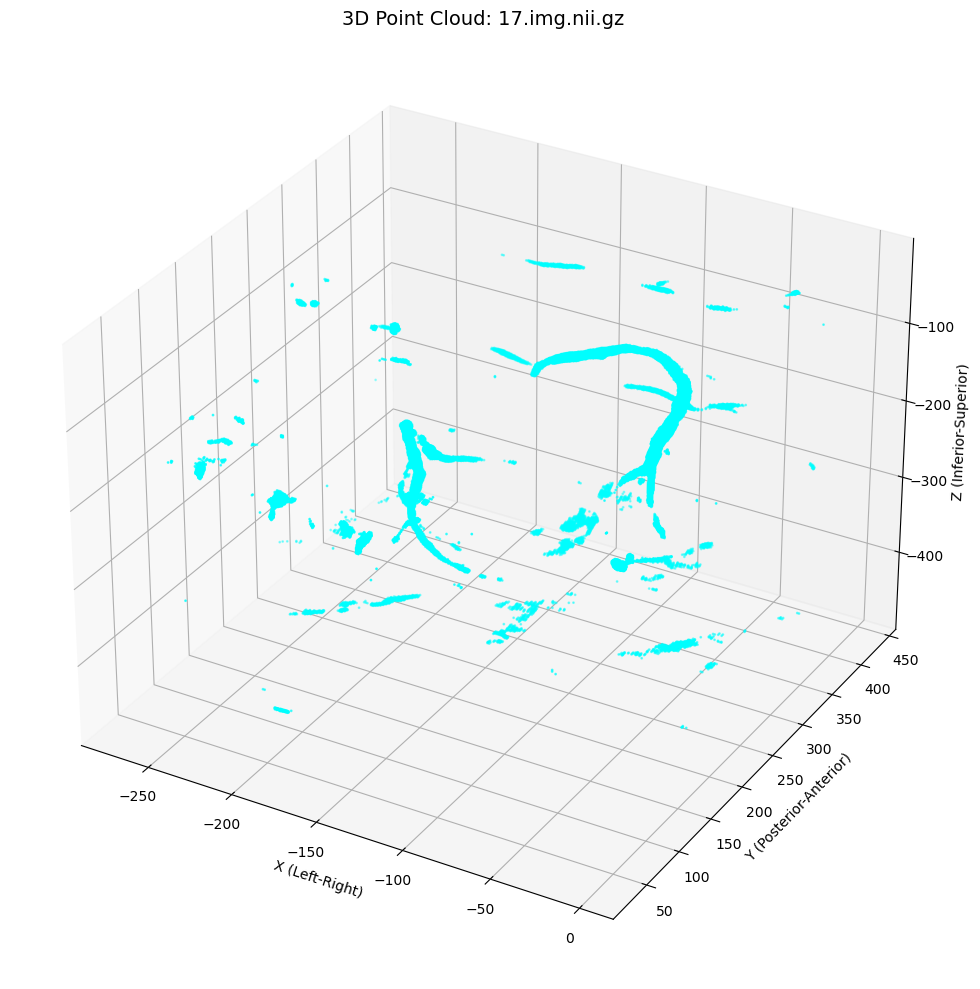

In [65]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load first prediction file
pred_dir = "predictions"
pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith(".nii.gz")])
fname = pred_files[8]
path = os.path.join(pred_dir, fname)

print(f"Visualizing as point cloud: {fname}")
nii = nib.load(path)
data = nii.get_fdata()

# Binarize the segmentation
mask = (data > 0.5)

# Get voxel coordinates in (Z, Y, X) order
z, y, x = np.where(mask)

# Optional: Flip axes for proper anatomical view
# You can toggle these based on how your data appears
x = -x  # Flip X (Left-Right)
z = -z  # Flip Z (Inferior-Superior)

# Plot point cloud
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1, c='cyan')

ax.set_title(f"3D Point Cloud: {fname}", fontsize=14)
ax.set_xlabel("X (Left-Right)")
ax.set_ylabel("Y (Posterior-Anterior)")
ax.set_zlabel("Z (Inferior-Superior)")
plt.tight_layout()
plt.savefig("my_segmentation_3d.png", dpi=300)
plt.show()



SyntaxError: invalid non-printable character U+00A0 (3722038218.py, line 65)